In [27]:
import numpy as np
import pandas as pd
import pickle

col_names = pd.read_csv('../data/dataset.csv', nrows=0).columns
dtype_map = {'class' : np.int16, 'bankruptcy_after_years' : np.int16}
dtype_map.update({col: np.float64 for col in col_names if col not in dtype_map})

df = pd.read_csv('../data/dataset.csv', dtype=dtype_map)
df = df.drop([df.columns[0], df.columns[1], df.columns[2], 'year'], axis=1)
df.drop_duplicates(keep=False, inplace=True)

df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after_years
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0


XGBoost model and k-fold cross-validation, binary classification:

In [11]:
import numpy as np
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt
   
    
def save_model(model, frs, label, out_dir):
    model.fit(frs, label)
    pickle.dump(model, open(out_dir,'wb'))


def validate(in_dir, frs, label):
    model = pickle.load(open(in_dir,'rb'))
    y_probas = model.predict_proba(frs)
    plot_precision_recall(label, y_probas)
    plt.show()

In [3]:
df['bankruptcy_after_years'].value_counts()

0    40534
2      511
3      491
1      406
4      396
5      271
Name: bankruptcy_after_years, dtype: int64

Impute missing values and perform SMOTE (Synthetic Minority Over-sampling) for balancing data:

In [4]:
from sklearn.impute import SimpleImputer
import gc
import numpy as np
from imblearn.over_sampling import SMOTE

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_data = imp.fit_transform(df)
imp_data_df = pd.DataFrame(imp_data, index=df.index, columns=df.columns)

X = imp_data_df[imp_data_df.columns.difference(['bankruptcy_after_years', 'class'])]
Y = imp_data_df['bankruptcy_after_years']

del imp_data, imp_data_df
gc.collect()


sm = SMOTE(random_state=111)
X_smote, y_smote = sm.fit_resample(X, Y)

Random undersampling with kept missing values for balancing data:

In [28]:
from imblearn.under_sampling import RandomUnderSampler

all_frs = df[df.columns.difference(['bankruptcy_after_years', 'class'])] # with NaNs
label = df['bankruptcy_after_years']

rus = RandomUnderSampler(random_state=111)
X_rus, y_rus = rus.fit_resample(all_frs, df['bankruptcy_after_years'])

In [29]:
all_frs.shape

(42609, 64)

In [30]:
label.shape

(42609,)

Save models:
1. XGBoost classifier with original data distribution and missing values kept;
2. Random forest classifier with data balanced with SMOTE (missing values imputed);
3. Naive Bayes classifier with data balanced with SMOTE (missing values imputed);
4.  XGBoost classifier with data balanced by random undersampling and missing values kept.

In [31]:
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.naive_bayes import GaussianNB


models = [(xgboost.XGBClassifier(), all_frs, label, '../models/xgboost.pkl'),
          (RandomForestClassifier(), X_smote, y_smote, '../models/random_forest_SMOTE.pkl'),
          (GaussianNB(), X_smote, y_smote, '../models/gaussian_nb_SMOTE.pkl'),
          (xgboost.XGBClassifier(), X_rus, y_rus, '../models/xgboost_RUS.pkl'),
          (xgboost.XGBClassifier(), X_smote, y_smote, '../models/xgboost_SMOTE.pkl')
         ]

for clr, frs, label, out_dir in models:    
    save_model(clr, frs, label, out_dir)

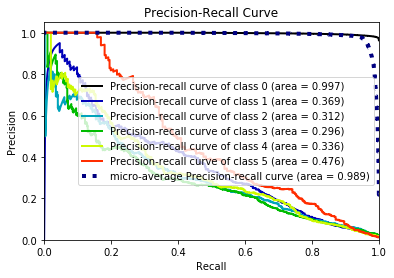

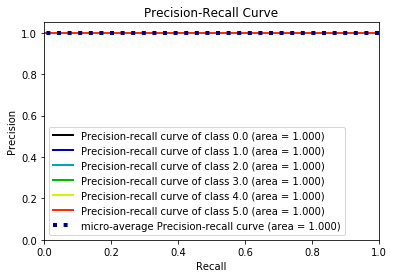

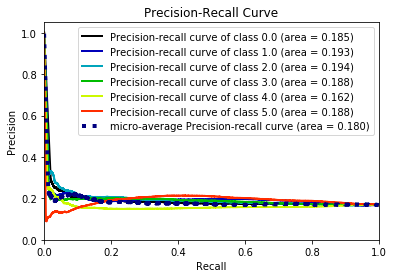

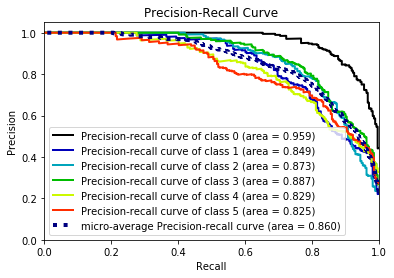

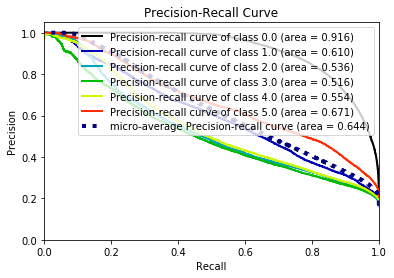

In [32]:
for _, frs, label, in_dir in models:    
    validate(in_dir, frs, label)

Results:
1. XGBoost classifier tends to classify non-bankrupted companies on the data with compamnies being non-bakrupted event rate more than 95%, thus classifier fails to classify other classes observations (AUC < 0.5);
2. Random forest classifier with default parameters is overfitted on oversampled and imputed data (SMOTE);
3. Naive Bayes classifier is overfitted on oversampled and imputed data (SMOTE);
4. XGBoost classifier performs well on the randomly undersampled data, but there is still high risk of missing representable observations from the data (data undersampled with respect to the minority classes that take only around 5% of all observations);
5. XGBoost classifier fitted to the data oversampled with SMOTE and imputed data leads to the mirco-average precision-recall rate only 0.644, but performs better in identifying classes compared with XGBoost classifier fitted on original imbalanced data.
